In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_12DLorenz.recursive_Markovian_PostMeanScore_12DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [3]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


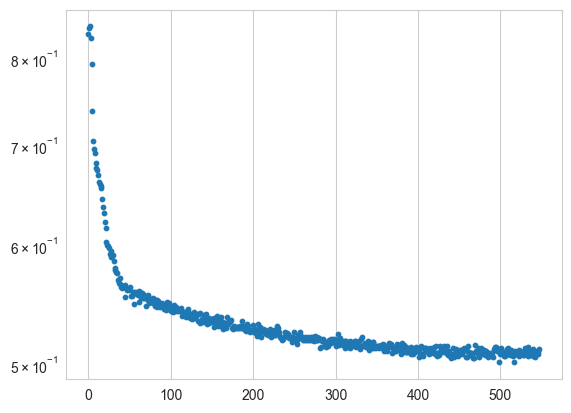

547

In [4]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

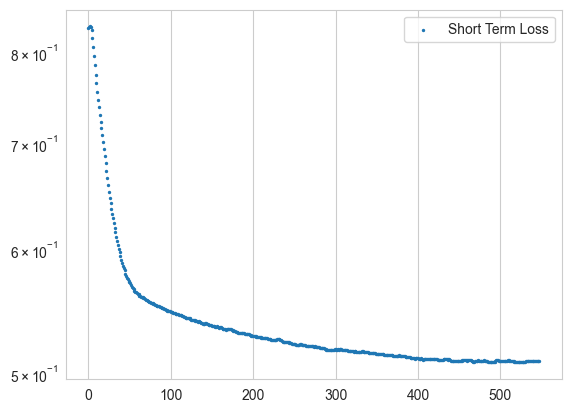

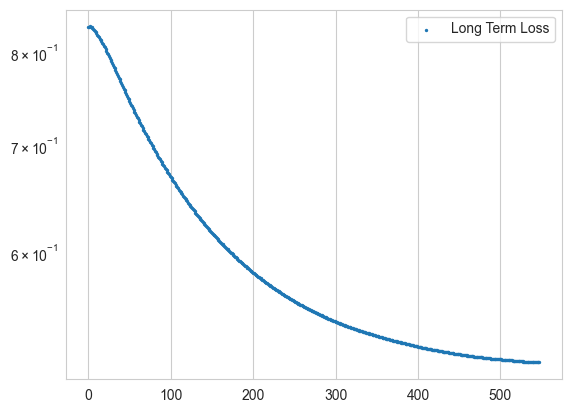

In [5]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

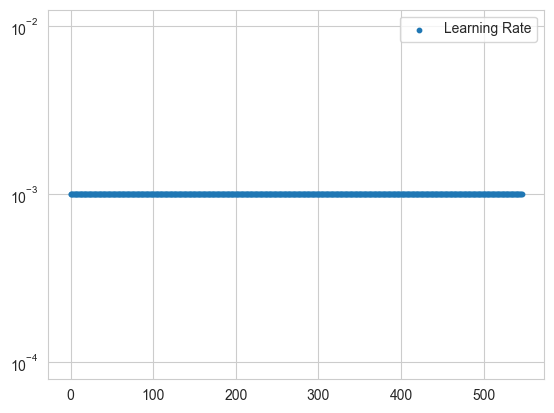

0


In [6]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(end-start+1)

In [7]:
def get_drift_files(config, root_dir):
    ts_type = f"ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz".replace(".", "")
    include =  (f"_{1}NDT_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/12DLnz/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "MLP_" in file and ts_type in file and include in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_score_dir+file)
            elif "DriftTrack" in file and "global" in file:
                driftoostrack_local_files.append(root_score_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [8]:
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config,root_dir=root_dir)
len(Nepochs_track)

298

In [9]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_40120/4063213029.py:11: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_40120/4063213029.py:12: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


{1: 14.840923763910588,
 2: 12.833657108499544,
 4: 10.702056457255626,
 6: 6.071027257846024,
 8: 4.646117327573723,
 10: 3.8166581342311887,
 12: 3.9087952880594075,
 14: 4.037819048670811,
 16: 3.9443402206605183,
 18: 4.391600243644435,
 20: 4.519214398814252,
 22: 4.632683099775165,
 24: 5.120297624348034,
 26: 5.784461543922785,
 28: 6.2515413366906705,
 30: 5.326575021002954,
 32: 4.58234879701761,
 34: 4.961497108634805,
 36: 4.453975457719645,
 38: 4.199150285516609,
 40: 4.284924420406621,
 42: 4.582151828863876,
 44: 4.087082282493306,
 46: 4.324761786623173,
 48: 4.590065927215931,
 50: 4.22276285541821,
 52: 4.125399876765713,
 54: 4.028884346193573,
 56: 3.8601796255547525,
 58: 4.207441833439069,
 60: 4.273023313314225,
 62: 4.122135712526166,
 64: 4.285699692147322,
 66: 4.051776943626596,
 68: 4.50984687424533,
 70: 4.455977800894977,
 72: 4.338165113860497,
 74: 4.17161009122376,
 76: 4.117195005596546,
 78: 4.402722824642956,
 80: 4.534800172384179,
 82: 4.1628769826

In [10]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])

In [11]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(10, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == np.array(list(drift_track_rmses.keys())))[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

In [12]:
print(common_epochs)

[ 10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44
  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80
  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110 112 114 116
 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152
 154 156 158 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188
 190 192 194 196 198 200 202 204 206 208 210 212 214 216 218 220 222 224
 226 228 230 232 234 236 238 240 242 244 246 248 250 252 254 256 258 260
 262 264 266 268 270 272 274 276 278 280 282 284 286 288 290 292 294 296
 298 300 302 304 306 308 310 312 314 316 318 320 322 324 326 328 330 332
 334 336 338 340 342 344 346 348 350 352 354 356 358 360 362 364 366 368
 370 372 374 376 378 380 382 384 386 388 390 392 394 396 398 400 402 404
 406 408 410 412 414 416 418 420 422 424 426 428 430 432 434 436 438 440
 442 444 446 448 450 452 454 456 458 460 462 464 466 468 470 472 474 476
 478 480 482 484 486 488 490 492 494 496 498 500 50

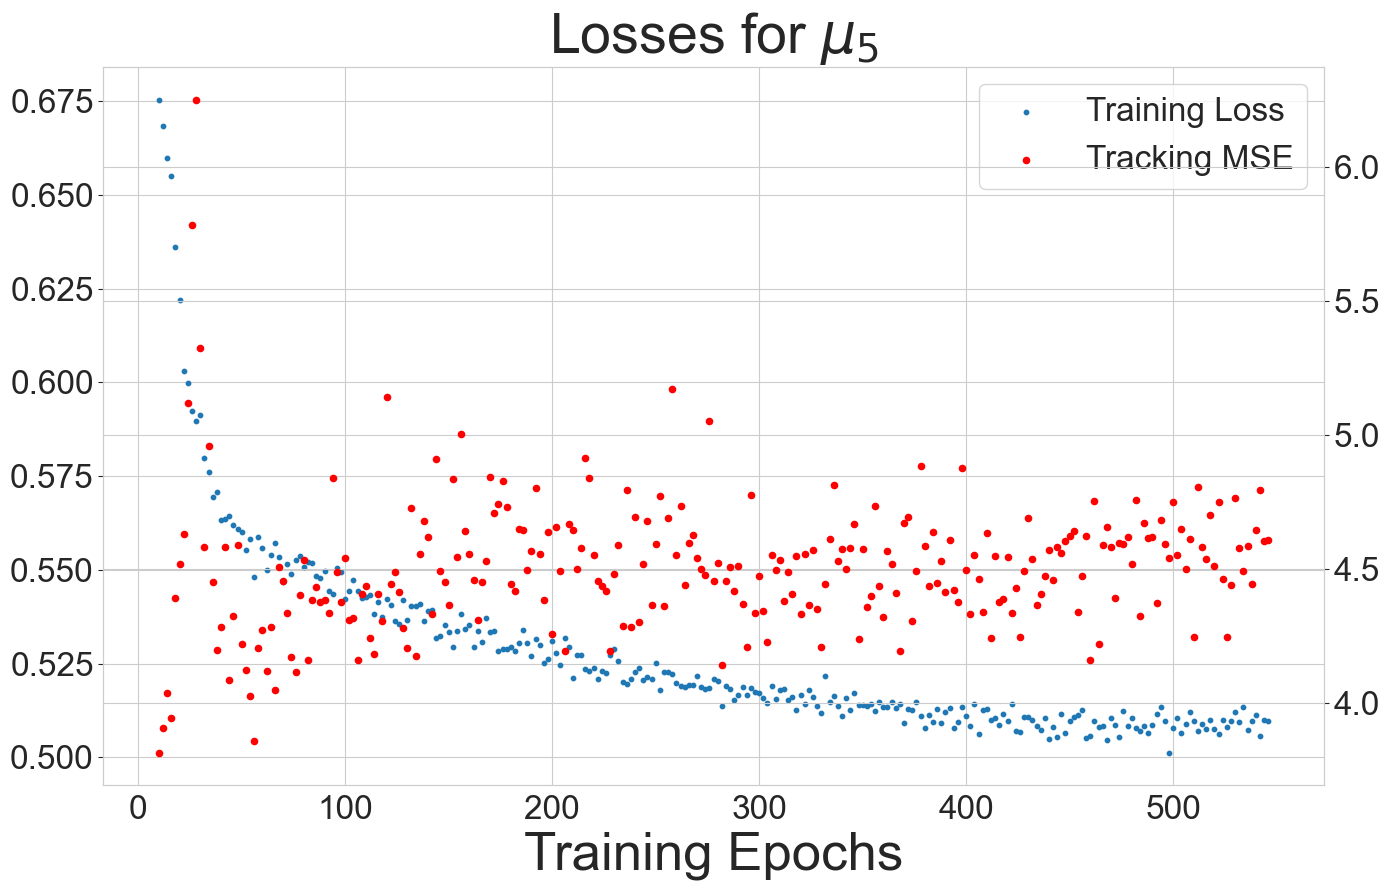

In [13]:
toSave = True
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
ax.set_title(r"Losses for $\mu_{5}$", fontsize=40)

#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/TSPM_Markovian/12DLnz/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_{config.forcing_const}FConst_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

(2, 100, 257, 12)


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_40120/1062597455.py:17: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_40120/1062597455.py:18: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


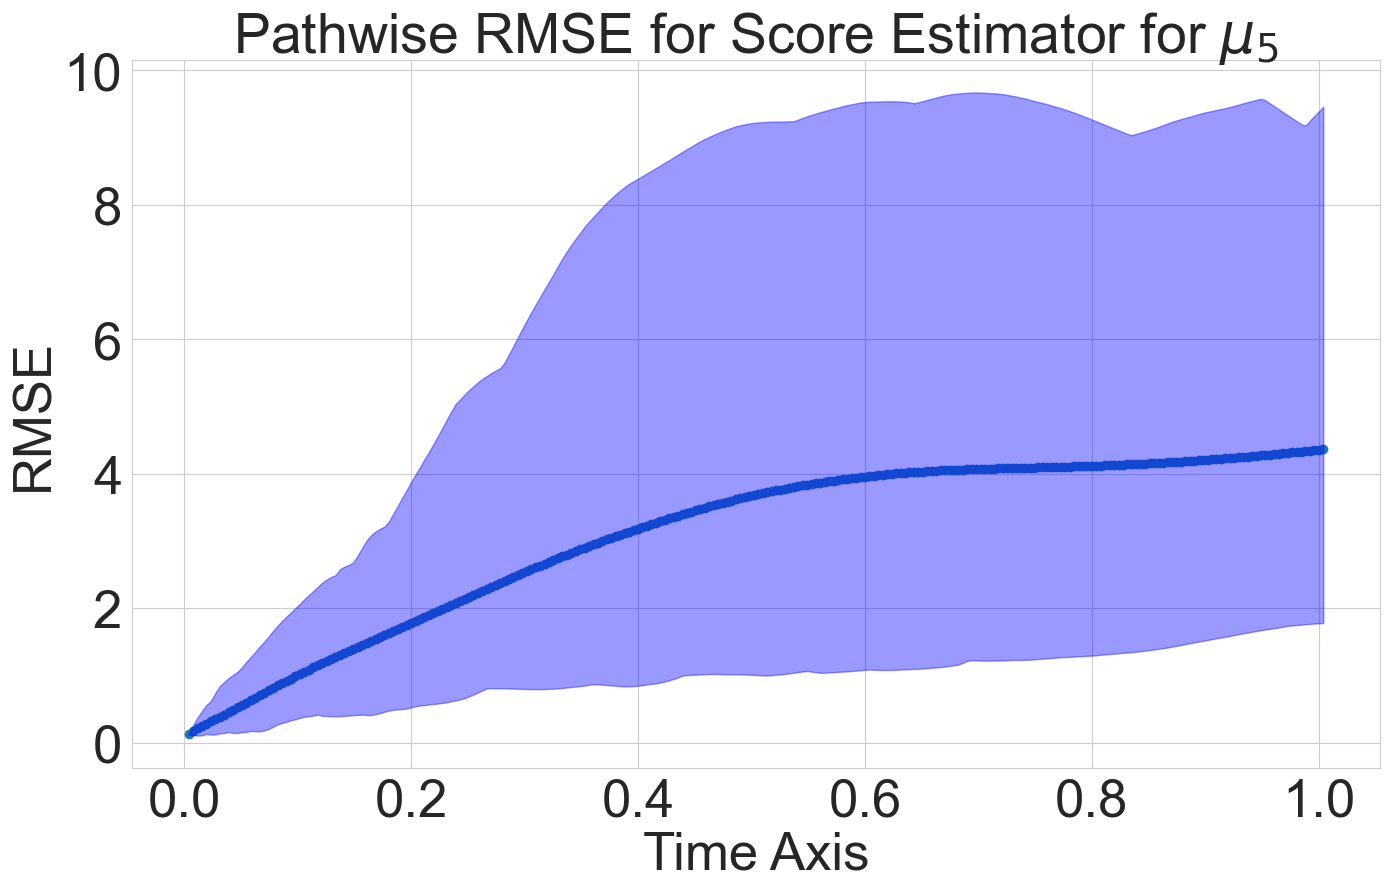

Final time cumulative MSE local-time error 4.366349015135421 with final IQR (1.7813370032225322, 9.458376915318096) at Nepoch 150 for 0.75FConst

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)


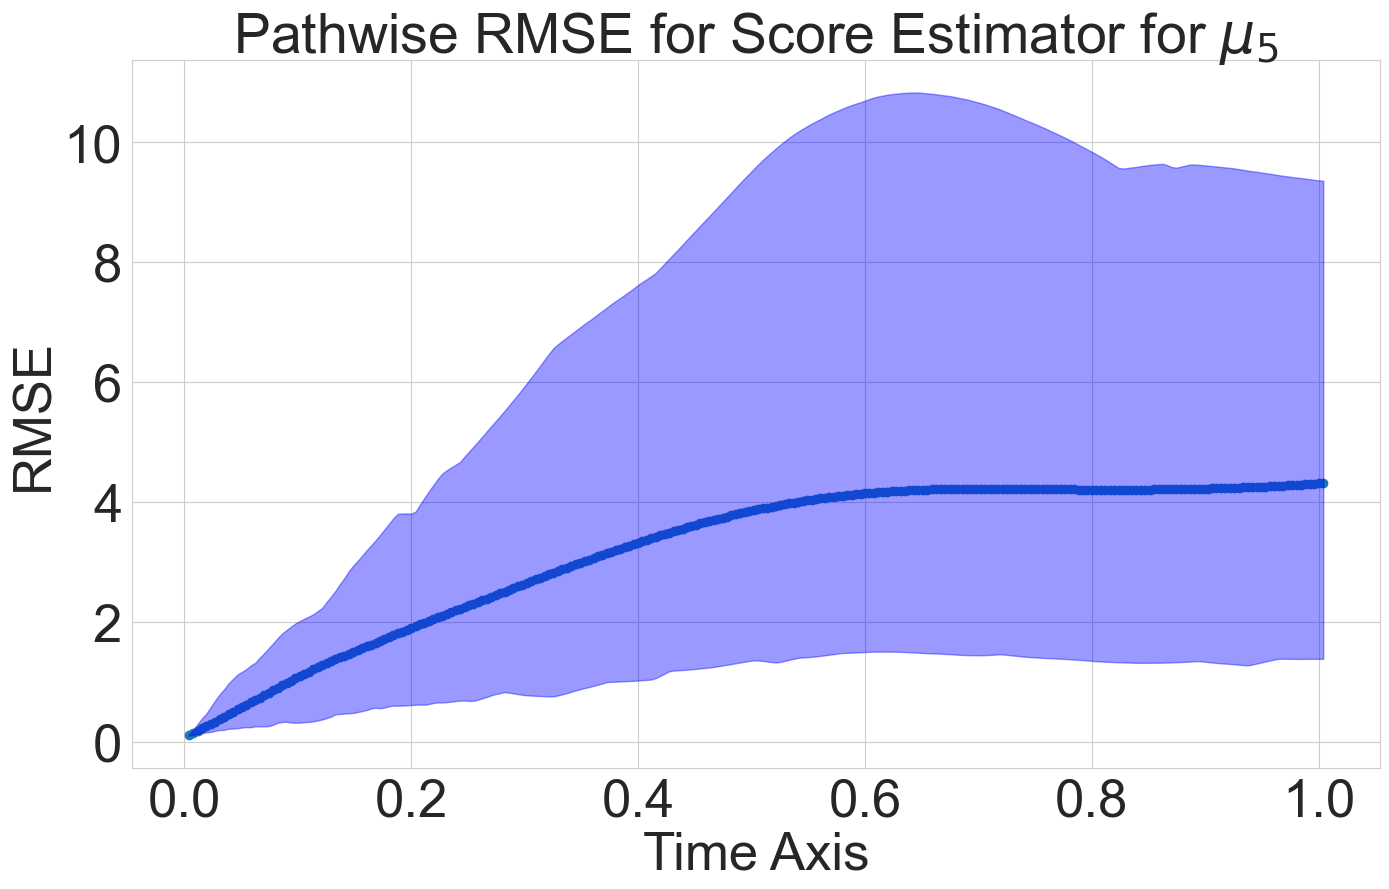

Final time cumulative MSE local-time error 4.311138227537574 with final IQR (1.3812239745631691, 9.352286353791191) at Nepoch 164 for 0.75FConst

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)


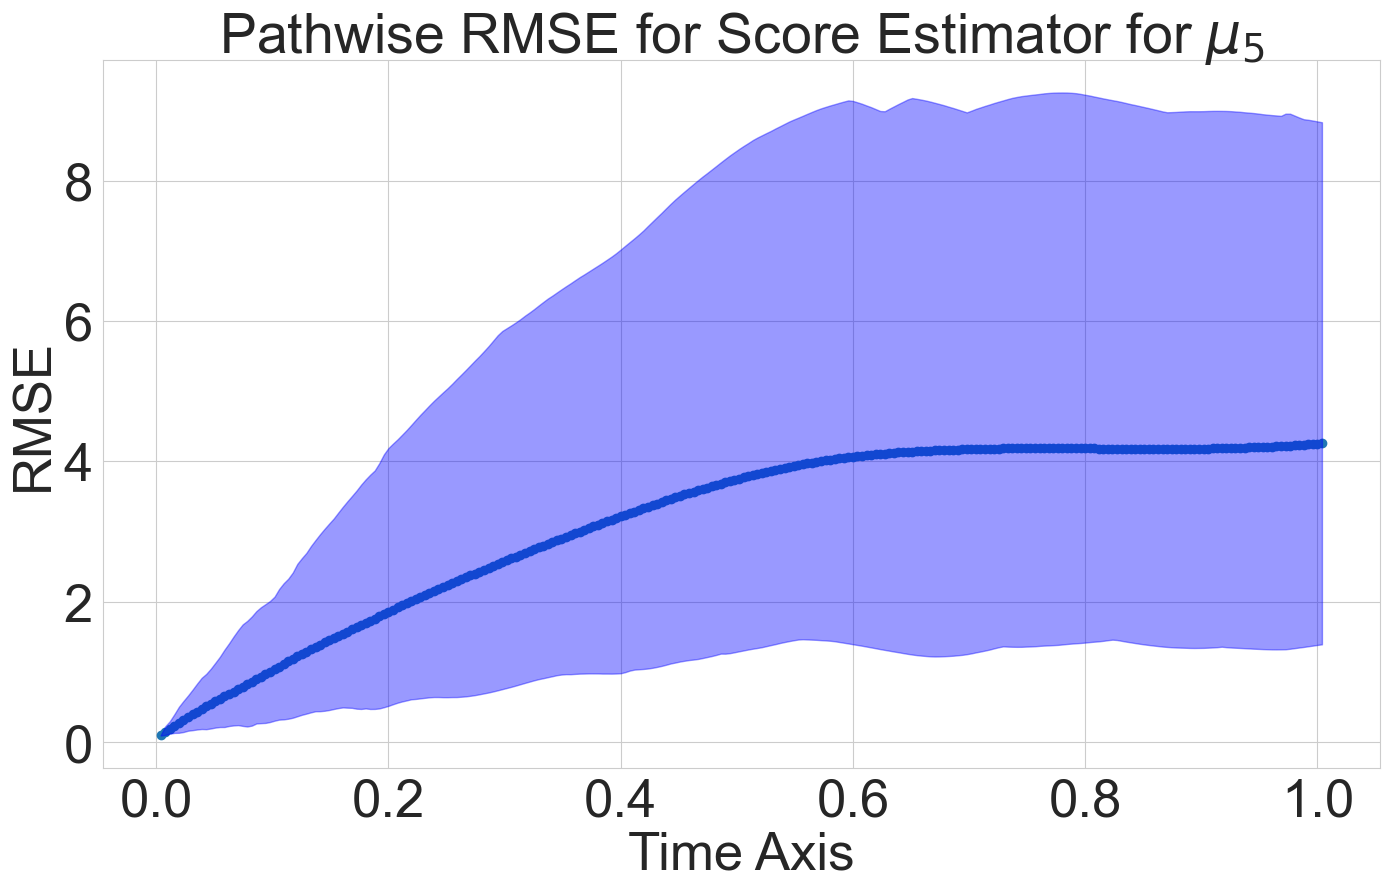

Final time cumulative MSE local-time error 4.257283960572777 with final IQR (1.3944554306215369, 8.830093428351784) at Nepoch 200 for 0.75FConst

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)


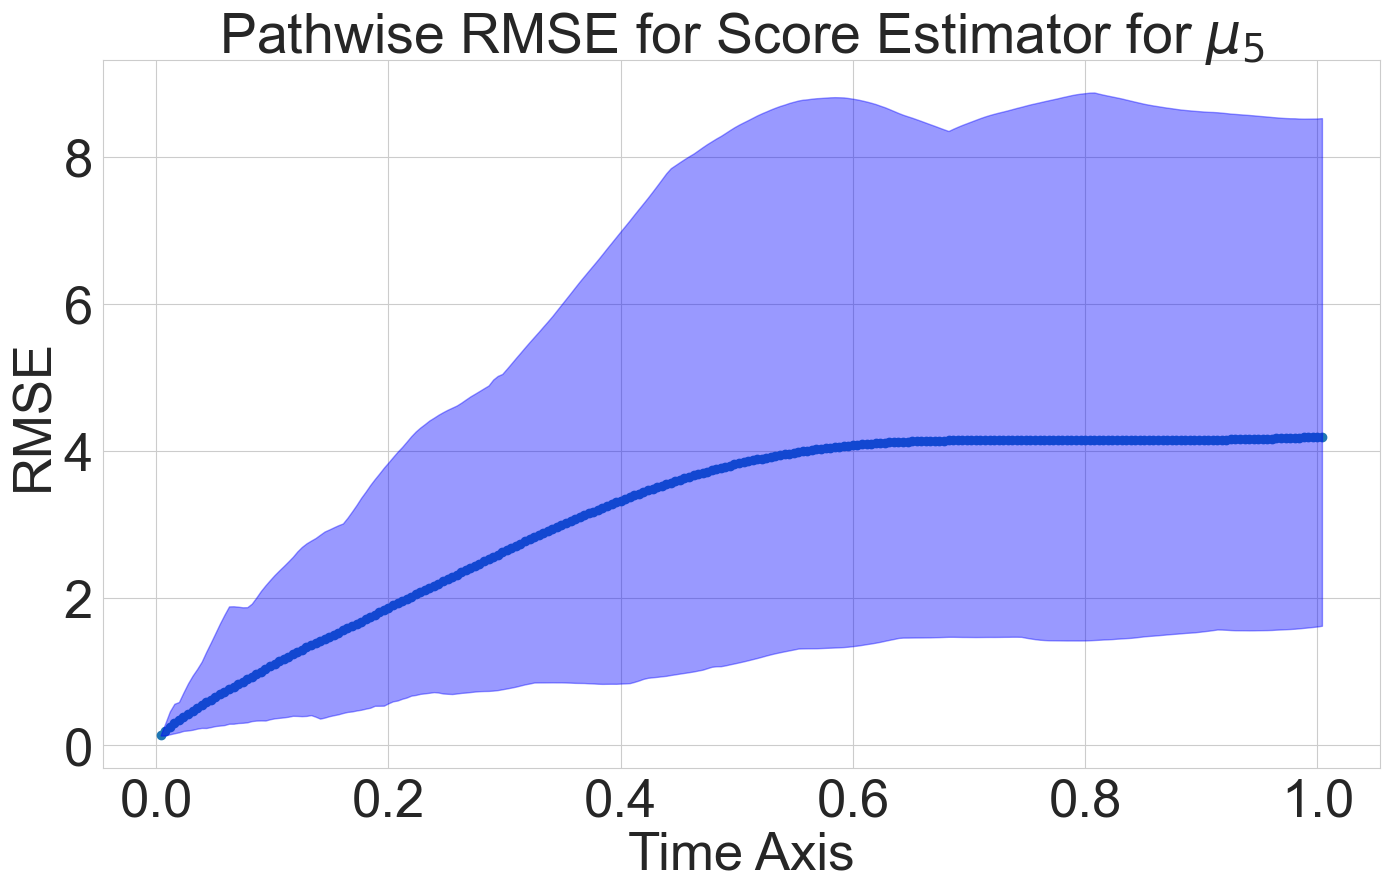

Final time cumulative MSE local-time error 4.196746662940674 with final IQR (1.626813347801709, 8.525664385963388) at Nepoch 206 for 0.75FConst

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)


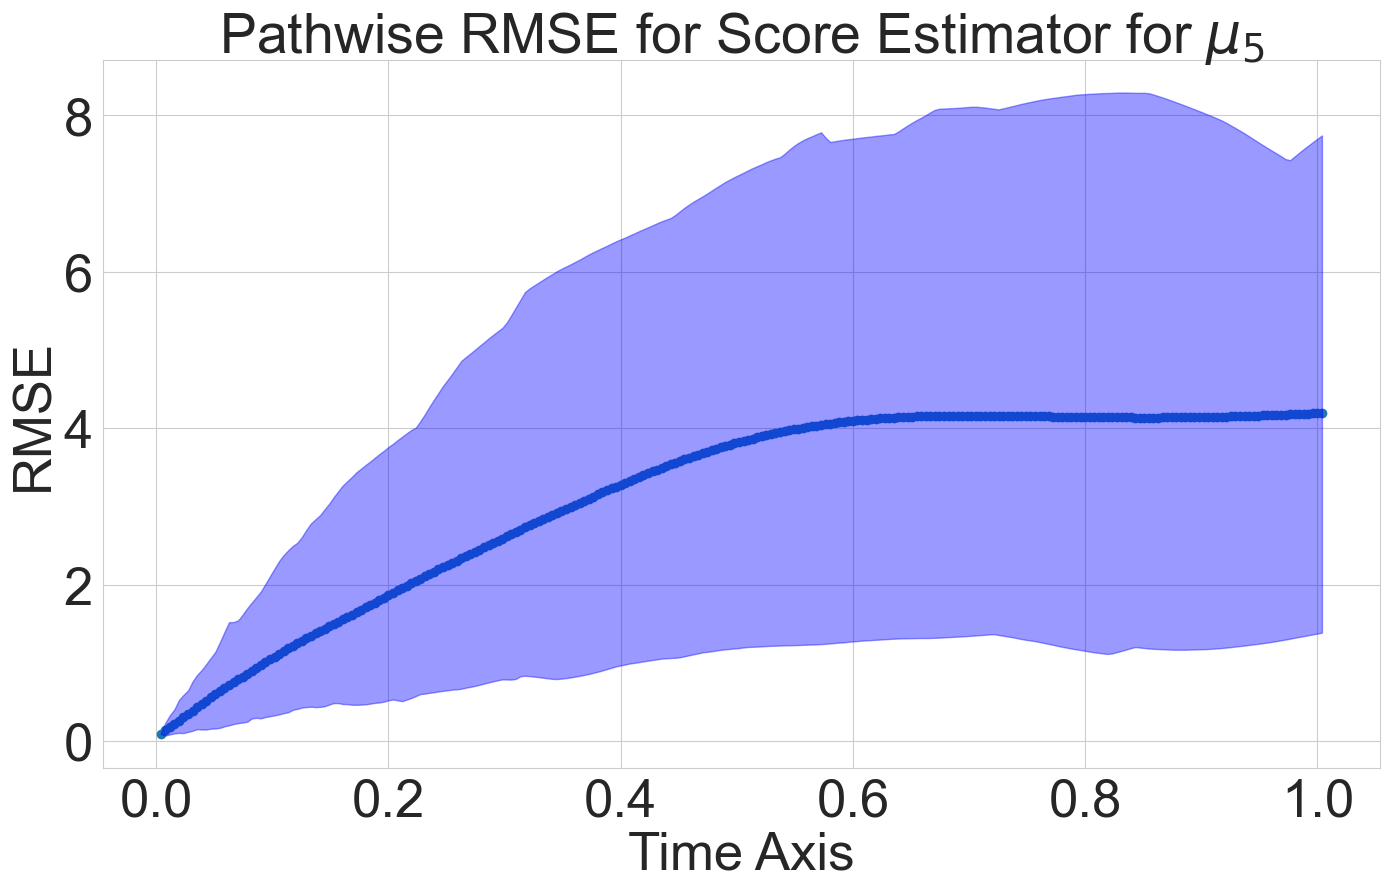

Final time cumulative MSE local-time error 4.193669097431553 with final IQR (1.384610842783841, 7.7418512025654405) at Nepoch 228 for 0.75FConst

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)


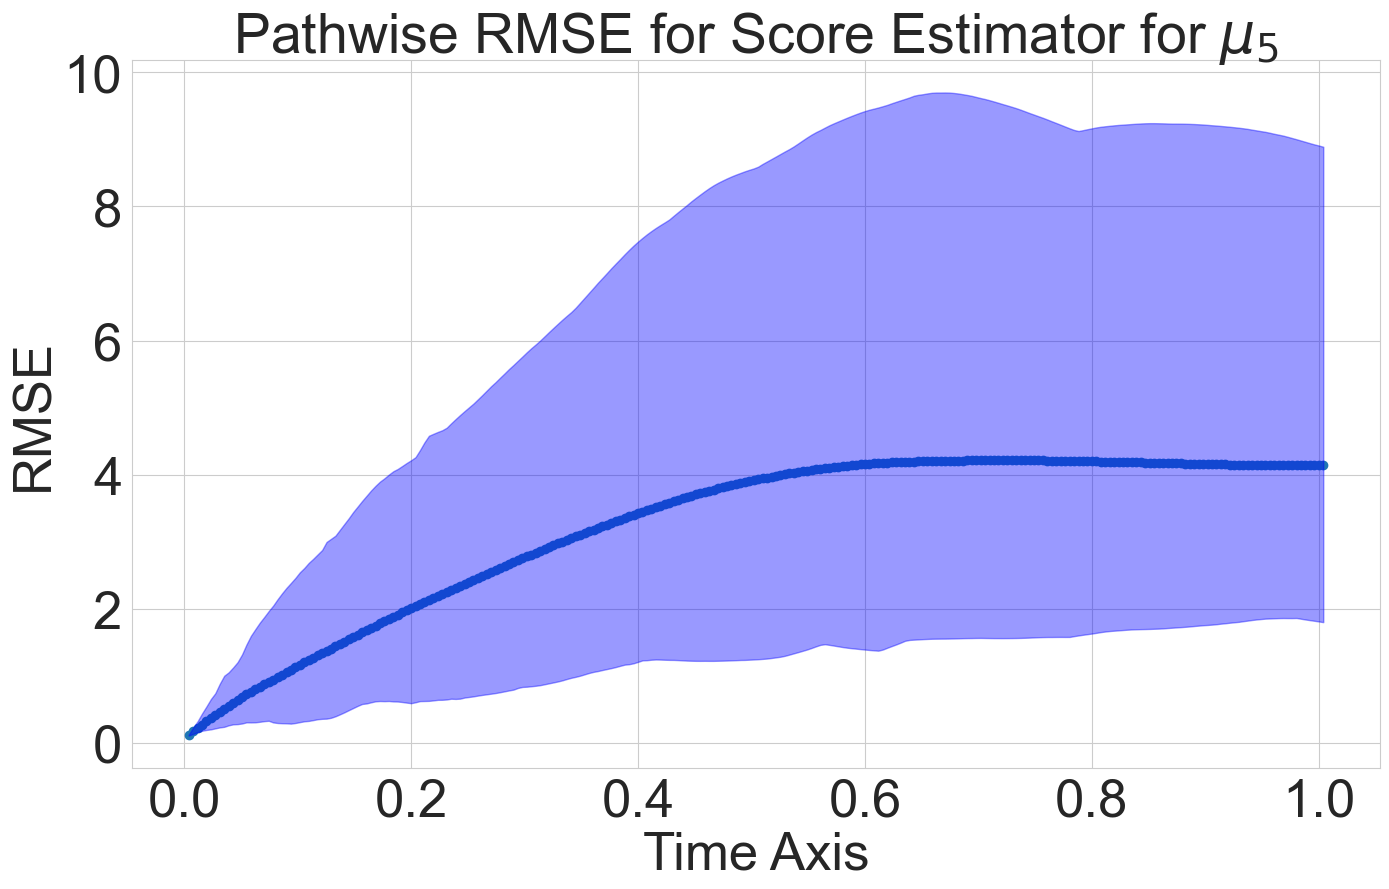

Final time cumulative MSE local-time error 4.1426465350192645 with final IQR (1.7995646705566202, 8.889616931056421) at Nepoch 282 for 0.75FConst

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100

In [14]:
curr_rmse = np.inf
toSave = True
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        if Nepoch < 150: raise FileNotFoundError
        num_diff_times = 1
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        print(all_local_states.shape)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Score Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/TSPM_Markovian/12DLnz/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_DriftTrack_{Nepoch}Nep_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue
# 0.021385787 final time error for 12DLnz at epoch 94 before changing final_tau = init_tau = 1.

In [15]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
import torch
scoreModel1 = ConditionalMarkovianTSPostMeanScoreMatching(
        *config.model_parameters)
rootdir = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/"
modelname = config.scoreNet_trained_path.replace(rootdir, "")
for file in os.listdir(rootdir):
    if modelname in file:
        scoreModel1.load_state_dict(torch.load(rootdir+file))
        print(file)
tau1 =  max(scoreModel1.mlp_state_mapper.hybrid.final_tau,
                          scoreModel1.mlp_state_mapper.hybrid.init_tau * (0.9 ** (94 // 20)))
scoreModel1.eval()
scoreModel2 = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters)
rootdir = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/snapshots/"
for file in os.listdir(rootdir):
    if modelname in file:
        scoreModel2.load_state_dict(torch.load(rootdir+file, map_location=torch.device("cpu"))["MODEL_STATE"])
scoreModel2.eval()
tau2 =  max(scoreModel2.mlp_state_mapper.hybrid.final_tau,
                          scoreModel2.mlp_state_mapper.hybrid.init_tau * (0.9 ** (Nepochs_losses[-1] // 20)))
print(tau1, tau2)

trained_rec_PM_ST_0010FTh_MLP_2LFac_12DLnz_750e-01FConst_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_MLP_H4_CUp20_tl110_NEp56


ModuleNotFoundError: No module named 'numpy._core'

In [ ]:
import torch

# Loop through named parameters
for (name_5, param_5), (name_20, param_20) in zip(scoreModel1.named_parameters(), scoreModel2.named_parameters()):
    assert name_5 == name_20  # Sanity check: same parameter names

    # Compute L2 norm of difference
    diff = torch.norm(param_5.data - param_20.data).item()
    print(f"{name_5}: L2 norm difference = {diff:.6f}")


In [ ]:
torch.mean(torch.exp(scoreModel2.mlp_state_mapper.hybrid.log_scale)), torch.mean(torch.sigmoid(scoreModel2.mlp_state_mapper.hybrid.gate_logits / 0.5)), scoreModel2.mlp_state_mapper.hybrid.tau

In [ ]:
Nepoch_good = 170000
Nepoch_bad = 300
good_idx = np.argwhere(common_epochs == Nepoch_good)[0,0]
bad_idx = np.argwhere(common_epochs == Nepoch_bad)[0,0]
good_true = np.load(drift_true_files[good_idx])[0, :, :, :]
good_local = np.load(drift_local_files[good_idx])[0, :,:, :]
bad_true = np.load(drift_true_files[bad_idx])[0, :, :, :]
bad_local = np.load(drift_local_files[bad_idx])[0, :, :,:]
print(bad_local.shape, bad_true.shape)
B, T, D = bad_local.shape

In [ ]:
for dim in range(config.ndims):
    dim_idx = dim + 1
    time_ax = np.linspace(config.t0,config.deltaT*T,T)
    # Print different "true sample paths"
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for _ in range(B):
        axes[0].scatter(time_ax, good_true[_, :, dim]-good_local[_, :, dim], color="red", s=1)
        axes[1].scatter(time_ax, bad_true[_, :, dim]-bad_local[_, :, dim], color="blue", s=1)
    plt.suptitle(f"True vs Score-Based Path Difference for Dimension {dim_idx}\n")
    plt.xlabel("Time")
    plt.ylabel("Path")
    plt.show()
    plt.close()